### Exploration (20 points)

Like in previous assignments, in this exercise you are meant to do creative exploration.  You don't need to write a book chapter, but the intention is for you to go beyond what's been covered above or explore new topic altogether.

One suggestion: Select a probabilistic programming package and work through and explain in your own words an example of interest to you from the documentation or tutorial.  Many of the simple tutorials will cover models similar to what we have discussed in class.  Be sure your explanation is from your own perspective and understanding; do not simply copy the tutorial.  You should add your own unique variations and modifications to better present the ideas or other things you found interesting.  The purpose of this exercise is simply to make you aware of some of the modern tools that are available for probabilistic modeling.  There are several packages available to choose from and they are all under active development as this is an active field of research.  In python, popular packages are [PyMC3](https://docs.pymc.io) and [TensorFlow Probability](https://www.tensorflow.org/probability).  In Julia, popular packages are [Gen](https://www.gen.dev) and [Turing](https://turing.ml/stable/).  There are many other choices, so feel free to choose something else if you find it interesting.

Alternatively, you can select a topic from the readings (Barber chapters 4, 5, and 27; Murphy chapters 19, 20, and 23; or Bishop Chapter 8) and write your own exercise.  It should aim to teach or explore a concept you don't understand or found interesting.  Like before, you don't do an excessive amount of work.  This isn't a project.  Aim for something worth about 20 points, i.e. about half as much work has exercise 1 but more than exercise 2.  See the rubric below for grading criteria.

#### Exploration Grading Rubric

Exploration problems will be graded according the elements in the table below.  The scores in the column headers indicate the number of points possible for each rubric element (given in the rows).  A score of zero for an element is possible if it is missing entirely.

|     | Substandard (+1) | Basic (+2) | Good (+3) | Excellent (+5) |
| :-- | :----------- | :---- | :--- | :-------- |
| <b> Pedagogical Value </b> | No clear statement of idea or concept being explored or explained; lack of motivating questions. | Simple problem with adequate motivation; still could be a useful addition to an assignment. | Good choice of problem with effective illustrations of concept(s).  Demonstrates a deeper level of understanding. | Problem also illustrates or clarifies common conceptual difficulties or misconceptions. |
| <b> Novelty of Ideas </b> | Copies existing problem or makes only a trivial modification; lack of citation(s) for source of inspiration. | Concepts are similar to those covered in the assignment but with some modifications of an existing exericse. | Ideas have clear pedagogical motivation; creates different type of problem or exercise to explore related or foundational concepts more deeply. | Applies a technique or explores concept not covered in the assignment or not discussed at length in lecture. | 
| <b> Clarity of Explanation </b> | Little or confusing explanation; figures lack labels or useful captions; no explanation of motivations. | Explanations are present, but unclear, unfocused, wordy or contain too much technical detail. | Clear and concise explanations of key ideas and motivations. | Also clear and concise, but includes illustrative figures; could be read and understood by students from a variety of backgrounds. |
| <b> Depth of Exploration </b> | Content is obvious or closely imitates assignment problems. | Uses existing problem for different data. | Applies a variation of a technique to solve a problem with an interesting motivation; explores a concept in a series of related problems. | Applies several concepts or techniques; has clear focus of inquiry that is approached from multiple directions.|

In [1]:
import numpy as np
from random import shuffle
import cv2

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rc('image', cmap='gray')

## The Problem
In A3, we explored denoising images as a part of problem 1. However, what is interesting to me is denoising color images. As a photographer, sometimes a lack of light may cause increased noise to be in the image because of a need to use higher ISO settings. At the end of this exploration, I hope to apply the method that I develop to a noisy image that I recently took in Death Valley National Park. This noisy image, while a beautiful view Zabriskie Point, I would like to print as a 36x48 sized photo that I can put up or sell in the future. Therefore, denoising this image properly may increase the value of the image. The image I would like to apply this denoising to is shown below:<br><br>
![View from Zabriskie Point](deathvalley.png "View from Zabriskie Point")<br><br>
Obviously, however, this 4k image will take a while to denoise. I therefore, have this smaller sized image which I will test denoising on before applying my developed method to the dealth valley photo<br><br>
![Color Wheel](colorwheel.png "Color Wheel test image")

### The Goal
Denoising images is fairly complex. Via experimentation and reading some research papers, I hope to implement a denoising method that reults in something similar to the following

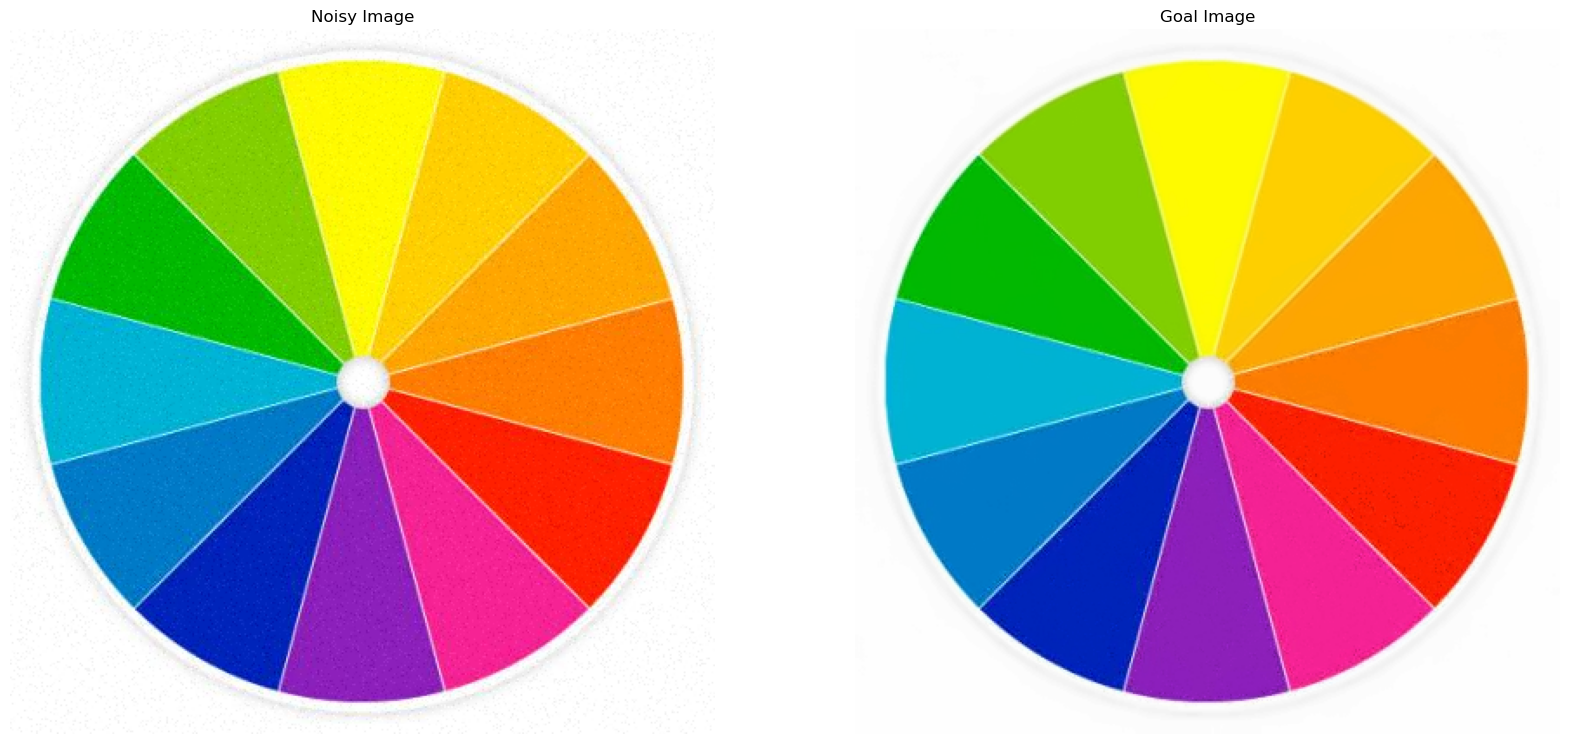

In [2]:
#read the image
noisy = cv2.cvtColor(cv2.imread("noisy_colorwheel.png"), cv2.COLOR_BGR2RGB)

# denoising with opencv
denoised_goal = cv2.fastNlMeansDenoisingColored(noisy)

# plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(20, 40)
ax[0].imshow(noisy); ax[0].set_title("Noisy Image"); ax[0].set_axis_off()
ax[1].imshow(denoised_goal); ax[1].set_title("Goal Image"); ax[1].set_axis_off()
plt.show()

Looking closely, you can see the reduced noise in the image on the right. This is the image that I will work to reproduce via this exploration

### Simple Denoising
Of course, the method I wrote for A3 will not work for this for a few reasons:<br>
1. There are three channels (R, G, B) in this image, which necessitates iteration over these three layers to remove noise from each (where each layer can be considered as a black and white image as noise reduction was performed on in A3)
2. The complexity of this image is much greater than the complexity of the image that I testing my denoising methods with. 
3. Color images are represented with continuous values from 0-1 or 0-255 rather than the simple binary method we developed earlier (-1 or 1)

Therefore, I have come up with a simple method that should (hopefully) work well for denoising color images. This method is very simple and I will continue to build on it in this exploration. It is outlined as follows:<br>
1. Take a pixel from the image
2. Consider neighbors of the the pixel of interest, compute the average of the neighbors (without the pixel of interest)
3. Replace the pixel of interest with the computed average. Over the scale of the image, this should give a gradual change in color
4. Loop over pixels and perform the same steps

While this method may provide some level of denoising, I can see this method having trouble near edges, where, for example, the line between the mountains and sky will be slightly blurred rather than being a sharp line. 

In [3]:
def denoise_average(img:np.array, cap:bool=False):
    # function to get the average of the neighbors (within the channel)
    def get_pixel_value(x, i, j, c):
        try:
            return x[i][j][c]
        except IndexError:
            return False
    
    # copy the img to make changes
    result = np.copy(img)
    
    # iterate over values, calc avg pixel, replace
    for l in range(img.shape[2]):
        for m in range(img.shape[0]):
            for n in range(img.shape[1]):
                
                # denoise using average
                avg = [val for val in [get_pixel_value(result, a, b, l) for a in [m-1,m,m+1] for b in [n-1,n,n+1]] if isinstance(val, np.uint8)]
                result[m][n][l] = np.mean(avg)
                
                if cap == True:
                    if m*n*l > img.size/2:
                        return result
    
    # return the necessary info
    return result

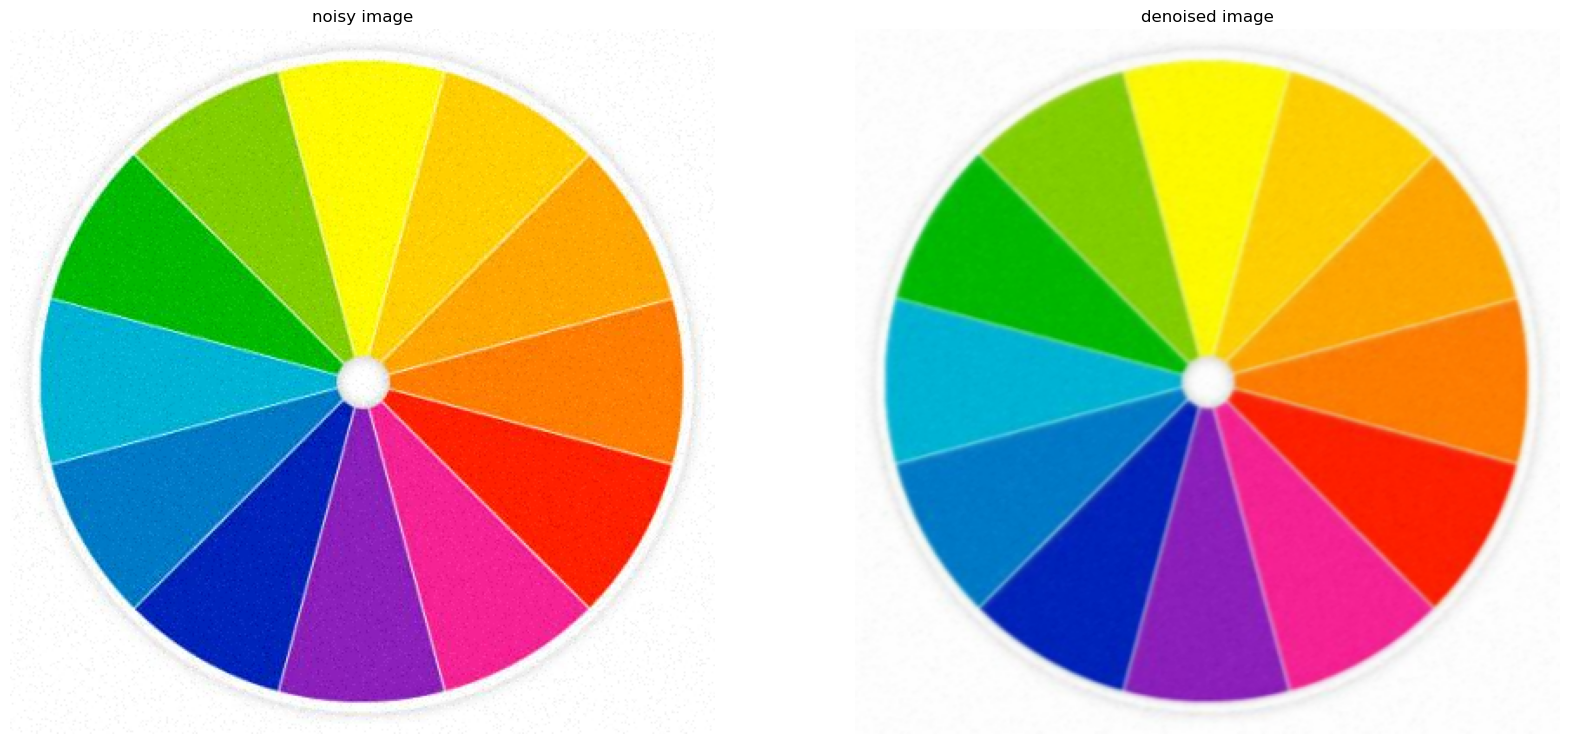

In [4]:
result = denoise_average(noisy, cap=False)

# show the images
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(20, 60)
ax[0].imshow(noisy)
ax[0].set_title("noisy image")
ax[0].set_axis_off()
ax[1].imshow(result)
ax[1].set_title("denoised image")
ax[1].set_axis_off()
plt.show()

We can see that while this method worked to some degree, there is still a level of unwanted blur that is being introduced. To combat this, rather than using a kernel to apply a filter to the image, we need to approach this probabilistically as we did the black and white denoising.<br><br>
Additionally, one can see that the white line which separates colors in the wheel, is not necessarily being denoised as the colors from one section bleed into another. This is not what is wanted, as this introduces a new problem which distinctly disallows a user from noticing the starting and ending points of an object in an image. Instead, we want to apply a method which reduces this "bleeding" property and instead increases the confidence in what a specific pixel should be.

### Probabilistic Denoising
In the past 20 years, image analysis has advanced far beyond applying a filter to an image to denoise images. Now, the industry leading standard is to apply a CNN-based method which is extremely powerful as it is generally trained on hundreds of thousands of image pairs (one noisy, one ground truth) which allows the model to learn how the image should be denoised based on parameterized weights. However, such a method is heavyweight and requires hundreds of thousands of training examples, and can take a while to train and predict what a denoised image looks like. Instead of employing deep learning methods, I will try to employ a probabilistic method which is outlined here:<br><br>
T. Xia, H. Dong, X. Wang, X. Yu, Y. Liu and X. Li, "Image Denoising Based on Dictionary Learning of Mean Corrected Atoms," 2019 IEEE/ACIS 18th International Conference on Computer and Information Science (ICIS), Beijing, China, 2019, pp. 202-207, doi: 10.1109/ICIS46139.2019.8940197.<br><br>
This algorithm presents a smart shortcut to denoising images. The argument presented is that for any image, the ground truth is unknown, the image that is captured is still mired with noise, whether large or small, from the settings used when capturing the image. However any image can be used as ground truth, noise applied to this image, and the ground truth "learned" from this difference.<br><br>
Somewhat confusing right? Think of it this way: 
- We have an image with noise -> consider this image to be the ground truth
- Generate a noisy image based on this ground truth image using a kernel (gaussian, normal, etc) based on the hypothesis of what type of noise is in the image
- Use the new noisy image with the original ground truth image to learn the noise pattern
- Apply the learned dictionary pattern to the original ground truth image to denoise it
- The learned dictionary noise should be representative of the noise added and should therefore denoise the ground truth image well.

Before writing any code to help with denoising these example images, some basics should be handled. I discuss Dictionary Learning and Orthogonal Matching Pursuit below.

#### Dictionary Learning
Dictionary Learning is a matrix factorization problem which results in finding a complete dictionary which will perform well at sparsely encoding the fitted data. Representing data as these sparse combinations has been suggested to be the way in which the mammalian visual cortex works. Applying dictionary learning to image patches has been shown to be a good method for image processing tasks such as image denoising, image completion, and inpainting. This optimization problem can be presented by the following equation:
$$ (U*,V*) = \text{argmin}_{U,V} (\frac{1}{2} \lVert X-UV \rVert_{Frobenius}^2 + \alpha \lVert U \rVert_{1,1}) $$ 
This is subject to the following:
$$ \lVert V_k \rVert_2 \le 1 \text{ for all } 0 \le k<n_{atoms} $$
where $ \lVert X \rVert_{Frobenius} $ is the Frobenius norm of $X$ and $ \lVert X \rVert_{1,1} $ is the entry-wise matrix norm of $X$.<br><br>
In this exploration, rather than producing my own implementation of dictionary learning, I will work with scikit-learn which has its own dictionary learning class which I will use in my implementation of image denoising

#### Orthogonal Matching Pursuit
Orthogonal Matching Pursuit (OMP) is based on a greedy algorithm that includes, at each step, the atom most highly correlated with the current residual. Being a forward feature selection method like Least Angle Regression, it can approximate the optimum selection vector with a fixed number of non-zero elements via the following equation:
$$ \text{argmin}_w \lVert y-Xw \rVert_2^2 $$
which is subject to the following:
$$ \lVert w \rVert_0 \le n_{\text{nonzero coeffs}} $$
Similarly to Dictionary Learning, I will use scikit-learn's implementation of OMP to make this exploration a bit more managable for myself as this will be my first time exploring both OMP and dictionary learning. In the future I look forward to learning more about these techniques and hopefully implementing them on my own

### Implementation

In [5]:
# read in the image
noisy = cv2.cvtColor(cv2.imread("noisy_colorwheel.png"), cv2.COLOR_BGR2RGB)
noisy.shape

(406, 406, 3)

#### Noising the image
First, with our noisy image, we assume it is the ground truth. To this image, we add some level of noise. Here, I will add noise only to half the image to help with showcasing how the noise can be removed from the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


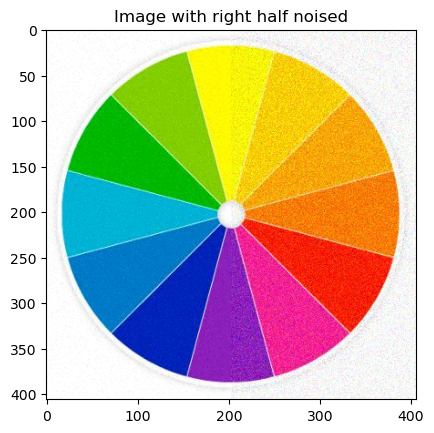

In [6]:
# convert image values from int(0, 255) to float(0, 1)
noisy = noisy / 255.0

# Distort only the right half of the image
height, width, channels = noisy.shape
distorted = noisy.copy()
distorted[:, width//2 :, :] += 0.075 * np.random.randn(height, width//2, channels)

# display the distorted image
plt.imshow(distorted)
plt.title("Image with right half noised")
plt.show()

#### Extracting Reference Patches
Next, we can extract reference patches to learn the dictionary from. This is done using scikit-learn's feature extraction toolbox. Since the reference patches should be from the ground truth, we extract these from the left half of the image rather than the right half. These reference patches can then be used to denoise the right half of the image.

In [7]:
# import from scikit-learn
from sklearn.feature_extraction.image import extract_patches_2d

# set parameters
patch_size = (7, 7)

# extract the patches
data = extract_patches_2d(distorted[:, : width // 2, :], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)

# show the number of patches
print(f"{data.shape[0]} patches extracted")

78800 patches extracted


#### Dictionary Learning
Now, we can learn the dictionary from the reference patches using scikit-learn's dictionary learning

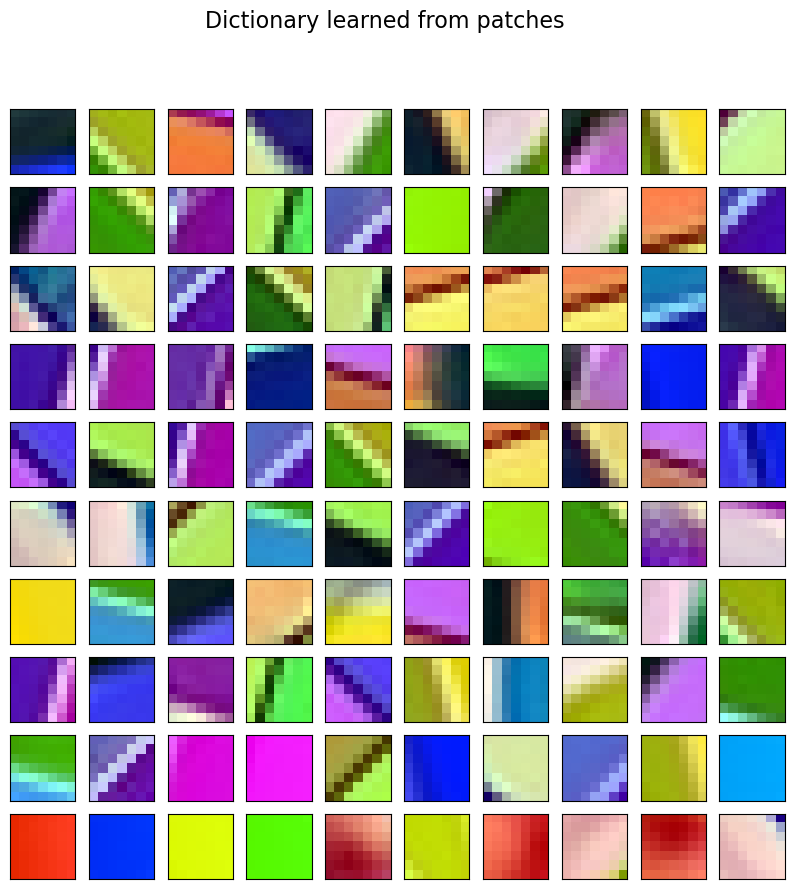

In [8]:
# import Dictionary Learning from sklearn
from sklearn.decomposition import MiniBatchDictionaryLearning

# learn the dictionary
dico = MiniBatchDictionaryLearning(
    n_components=100,
    batch_size=200,
    alpha=1.0,
    max_iter=10,
)
V = dico.fit(data).components_

# plot the learned dictionary
plt.figure(figsize=(10, 10))
for i, comp in enumerate(V[:100]):
    comp_norm = (comp-np.min(comp))/(np.max(comp)-np.min(comp))
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp_norm.reshape((7, 7, 3)))
    plt.xticks(())
    plt.yticks(())
plt.suptitle("Dictionary learned from patches", fontsize=16)
plt.show()

#### Orthogonal Matching Pursuit
Now that we have our dictionary, we can apply OMP to our data to try to reconstruct our non-noisy image. Here, I will also use scikit-learn to help with this. First, we now extract the noisy patches. Then we apply our dictionary to the noisy patches to try to match the noisy to the non-noisy data. Then, we do our best to transform the data given in the noisy scene with that in the non-noisy scene. We do this with several different values, which is why this process is known as a pursuit.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


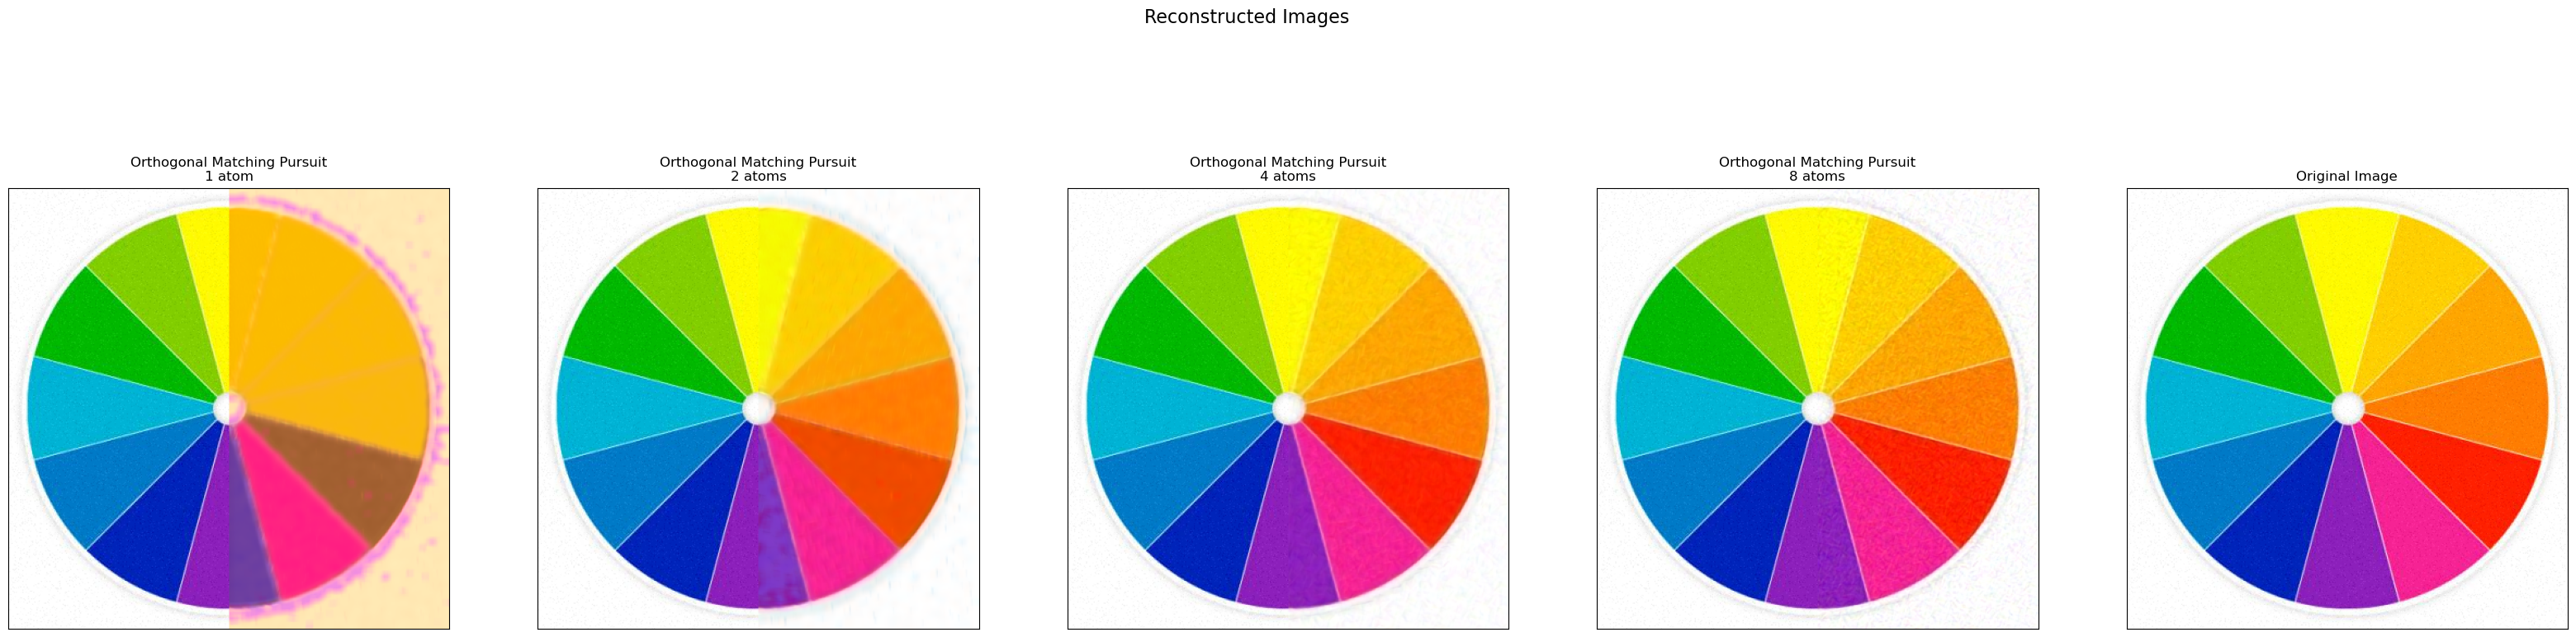

In [9]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

# extract the noisy patches
data = extract_patches_2d(distorted[:, width // 2 :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
    ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
    ("Orthogonal Matching Pursuit\n4 atoms", "omp", {"transform_n_nonzero_coefs": 4}),
    ("Orthogonal Matching Pursuit\n8 atoms", "omp", {"transform_n_nonzero_coefs": 8})
]

# set up for plotting
plt.figure(figsize=(40, 10))
i = 1

# reconstruct the image
reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    reconstructions[title] = noisy.copy()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *(7, 7, 3))
    if transform_algorithm == "threshold":
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2 :, :] = reconstruct_from_patches_2d(
        patches, (height, width // 2, channels)
    )
    
    # plot the denoised images
    plt.subplot(1, 5, i); i+=1
    plt.imshow(reconstructions[title])
    plt.title(title)
    plt.xticks(()); plt.yticks(())
    
# final plotting
plt.subplot(1, 5, i)
plt.imshow(noisy)
plt.title("Original Image")
plt.xticks(()); plt.yticks(())
plt.suptitle("Reconstructed Images", fontsize=16)
plt.show()

### Conclusions
We can see that this method for denoising did not work optimally at 1 atom, performed similar to our previous kernel method with 2 atoms, worked somewhat well at 4 atoms, and looks similar to the noiy image at 8 atoms. It is likely that somewhere between 2 and 4 atoms is where this method would work well to reproduce something similar to the original image. However, this image is also a bit of a bad example because of the color differences in the right and left sides of the image as is present in a color wheel. Therefore, the dictionary, while it is doing its best, cannot provide a good match at any point. This brings up a good limitation of this method:
- Reference patches must be good examples of the image as a whole
- Because we create a dictionary, we need the image to be somewhat homogenous in terms of color and features
- Additionally, dictionary learning is only meant to be used for grayscale images. Above is also my implementation of this using color images

This exploration was very interesting to me as it merged interests of photography and AI. It was very interesting also to learn a bit more in depth about image denoising. Because of the lack of ability for dictionary learning to denoise color images very well, I will not be trying this here on the photo shown above. For now, I will leave the image denoising to my photo editor, for which I am sure the programmers spent much more time than I did writing the algorithms to denoise images properly.